<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/CIFAR-10%20Image%20Classification%20with%20ResNet/ResNet_CIFAR10_ImageClassificationCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computer Vision**

**Most Common Problems in CV:**


*   **Image Classification**
*   **Object Detection**
*   **Image Segmentation**

![](https://drive.google.com/uc?id=1-KzUlCbJvWMFHtM-5XRB16TXI1pMp51W)

# **Image Classification with Convolutional Neural networks**

## **ResNet Architecture**
ResNet (Residual Network) is a deep neural network architecture that introduces skip connections (or residual connections), allowing input to bypass certain layers and be added directly to the output. This helps address the vanishing gradient problem and enables the training of very deep networks, sometimes over 100 layers, by simplifying optimization and preserving important features.


![](https://www.researchgate.net/profile/Yin-Shen-4/publication/343374745/figure/fig3/AS:922661106503680@1596990958634/Workflow-diagram-a-Typical-architecture-of-the-101-layer-ResNet-b-The-flowchart-of.png)




### Libraries

In [ ]:
import copy
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import random_split

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

### Setting Random Seeds

In [ ]:
SEED = 101

np.random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Retriving CIFAR10 Dataset

In [ ]:
# Definning Transformations
train_transforms = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

test_transforms = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [ ]:
# Download train set
train_data = datasets.CIFAR10(
    root="train_data",
    train=True,
    download=True,
    transform=train_transforms
)

# Down test set
test_data = datasets.CIFAR10(
    root="test_data",
    train=False,
    download=True,
    transform=test_transforms
)

100%|██████████| 170498071/170498071 [00:04<00:00, 34401508.62it/s]


Extracting train_data/cifar-10-python.tar.gz to train_data


100%|██████████| 170498071/170498071 [00:03<00:00, 48695861.81it/s]


Extracting test_data/cifar-10-python.tar.gz to test_data


# Training & Validation Sets

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples])

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

# Creating Dataloaders for Train, Validation & Test Sets

In [ ]:
BATCH_SIZE = 32

# Train Set
train_loader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)

# Validation
valid_loader = data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE
)

# Test Set
test_loader = data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)

# ResNet Implementation

In [ ]:
# ResNet Block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet Model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Instantiate the ResNet18 model
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
# Definning Model
OUTPUT_DIM = 10
model = ResNet18()

In [ ]:
# !pip install torchinfo

In [ ]:
from torchinfo import summary

summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 32, 32]           864
├─BatchNorm2d: 1-2                       [1, 32, 32, 32]           64
├─Sequential: 1-3                        [1, 32, 32, 32]           --
│    └─BasicBlock: 2-1                   [1, 32, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 32, 32, 32]           9,216
│    │    └─BatchNorm2d: 3-2             [1, 32, 32, 32]           64
│    │    └─Conv2d: 3-3                  [1, 32, 32, 32]           9,216
│    │    └─BatchNorm2d: 3-4             [1, 32, 32, 32]           64
│    │    └─Sequential: 3-5              [1, 32, 32, 32]           --
│    └─BasicBlock: 2-2                   [1, 32, 32, 32]           --
│    │    └─Conv2d: 3-6                  [1, 32, 32, 32]           9,216
│    │    └─BatchNorm2d: 3-7             [1, 32, 32, 32]           64
│    

## Setting the Optimizer & Criterion

In [ ]:
# Define Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define Criterion
criterion = nn.CrossEntropyLoss()

## Training on GPU

In [ ]:
# Define Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set Model & Loss fn to Device
model = model.to(device)
criterion = criterion.to(device)

## Method To Calculate Accuracy

In [ ]:
def calculate_accuracy(pred, y):
    top_pred = pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

## Method to Perform Training Epochs

In [ ]:
def train(model, dataloader, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for features, labels in tqdm(dataloader, desc="Training Phase", leave=False):
        # Sending features and labels to device
        features = features.to(device)
        labels = labels.to(device)

        # Forward pass; making predictions and calculating loss
        pred = model(features)
        loss = criterion(pred, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculating accuracies
        acc = calculate_accuracy(pred, labels)
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

## Method to Perform Evaluation Epochs

In [ ]:
def evaluate(model, dataloader, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for features, labels in tqdm(dataloader,
                                     desc="Evaluation Phase",
                                     leave=False):

            features = features.to(device)
            labels = labels.to(device)

            pred = model(features)

            loss = criterion(pred, labels)

            acc = calculate_accuracy(pred, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

# Model Training On Train Set

In [ ]:
EPOCHS = 25

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in trange(EPOCHS, desc="Epoch Number"):
    # Train Phase
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    # Append result to dict
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Evaluating Phase
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
    # Append results to dict
    history['val_loss'].append(valid_loss)
    history['val_acc'].append(valid_acc)

    # Printing Info
    print(f"Epoch: [{epoch+1:02}]")
    print(f"\tTraining Loss: {train_loss:>7.3f} || Training Accuracy: {train_acc*100:>7.2f}%")
    print(f"\tValidation Loss: {valid_loss:>7.3f} || Validation Accuracy: {valid_acc*100:>7.2f}%")

Epoch Number:   0%|          | 0/25 [00:00<?, ?it/s]

Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [01]
	Training Loss:   0.118 || Training Accuracy:   96.15%
	Validation Loss:   0.877 || Validation Accuracy:   81.21%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [02]
	Training Loss:   0.069 || Training Accuracy:   97.62%
	Validation Loss:   1.033 || Validation Accuracy:   80.73%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [03]
	Training Loss:   0.058 || Training Accuracy:   98.10%
	Validation Loss:   1.086 || Validation Accuracy:   80.57%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [04]
	Training Loss:   0.060 || Training Accuracy:   97.97%
	Validation Loss:   1.026 || Validation Accuracy:   81.75%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [05]
	Training Loss:   0.056 || Training Accuracy:   98.15%
	Validation Loss:   0.990 || Validation Accuracy:   82.03%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [06]
	Training Loss:   0.055 || Training Accuracy:   98.21%
	Validation Loss:   1.011 || Validation Accuracy:   82.48%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [07]
	Training Loss:   0.054 || Training Accuracy:   98.20%
	Validation Loss:   0.973 || Validation Accuracy:   81.47%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [08]
	Training Loss:   0.048 || Training Accuracy:   98.40%
	Validation Loss:   1.019 || Validation Accuracy:   82.56%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [09]
	Training Loss:   0.045 || Training Accuracy:   98.55%
	Validation Loss:   1.070 || Validation Accuracy:   81.87%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [10]
	Training Loss:   0.052 || Training Accuracy:   98.31%
	Validation Loss:   1.134 || Validation Accuracy:   81.51%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [11]
	Training Loss:   0.045 || Training Accuracy:   98.60%
	Validation Loss:   1.104 || Validation Accuracy:   81.23%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [12]
	Training Loss:   0.042 || Training Accuracy:   98.71%
	Validation Loss:   1.042 || Validation Accuracy:   82.76%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [13]
	Training Loss:   0.047 || Training Accuracy:   98.56%
	Validation Loss:   0.996 || Validation Accuracy:   83.16%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [14]
	Training Loss:   0.038 || Training Accuracy:   98.76%
	Validation Loss:   1.171 || Validation Accuracy:   81.81%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [15]
	Training Loss:   0.040 || Training Accuracy:   98.69%
	Validation Loss:   1.038 || Validation Accuracy:   82.88%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [16]
	Training Loss:   0.037 || Training Accuracy:   98.80%
	Validation Loss:   1.269 || Validation Accuracy:   81.59%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [17]
	Training Loss:   0.036 || Training Accuracy:   98.83%
	Validation Loss:   1.283 || Validation Accuracy:   80.65%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [18]
	Training Loss:   0.041 || Training Accuracy:   98.68%
	Validation Loss:   1.212 || Validation Accuracy:   81.81%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [19]
	Training Loss:   0.035 || Training Accuracy:   98.95%
	Validation Loss:   1.180 || Validation Accuracy:   82.44%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [20]
	Training Loss:   0.036 || Training Accuracy:   98.87%
	Validation Loss:   1.308 || Validation Accuracy:   82.11%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [21]
	Training Loss:   0.033 || Training Accuracy:   99.04%
	Validation Loss:   1.223 || Validation Accuracy:   81.81%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [22]
	Training Loss:   0.034 || Training Accuracy:   98.93%
	Validation Loss:   1.222 || Validation Accuracy:   82.19%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [23]
	Training Loss:   0.037 || Training Accuracy:   98.85%
	Validation Loss:   1.276 || Validation Accuracy:   82.19%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [24]
	Training Loss:   0.034 || Training Accuracy:   98.94%
	Validation Loss:   1.259 || Validation Accuracy:   81.95%


Training Phase:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluation Phase:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [25]
	Training Loss:   0.033 || Training Accuracy:   99.04%
	Validation Loss:   1.368 || Validation Accuracy:   82.23%


## Saving Model

In [ ]:
torch.save(model.state_dict(), 'cifar10_resnet.pt')

## Evaluating On Test Set

In [ ]:
model.load_state_dict(torch.load('cifar10_resnet.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc*100:.2f}%')

<ipython-input-61-7d4f4bd00e1e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cifar10_resnet.pt'))


Evaluation Phase:   0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 1.430 | Test Accuracy: 80.96%


# Confusion Matrix

In [ ]:
def get_preds(model, dataloader, device):
    model.eval()

    images_list, labels_list, probs_list = [], [], []

    with torch.no_grad():

        for features, labels in dataloader:

            features = features.to(device)

            pred = model(features)

            prob = F.softmax(pred, dim=-1)

            images_list.append(features.cpu())
            labels_list.append(labels.cpu())
            probs_list.append(prob.cpu())

    images = torch.cat(images_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    probs = torch.cat(probs_list, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_preds(model, test_loader, device)

pred_labels = torch.argmax(probs, 1)

In [ ]:
print(train_data.dataset.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


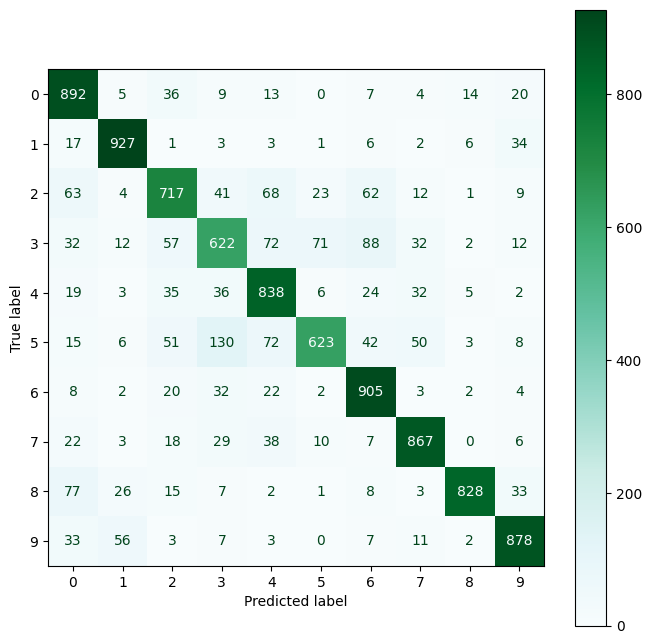

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
cm = confusion_matrix(labels, pred_labels)
cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
cm.plot(values_format='d', cmap='BuGn', ax=ax);